In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import torch
from scipy.integrate import simps
import scipy.stats as stats
import os
cwd = os.getcwd()

In [2]:
from FourierGridMethod import Fourier_Grid,normalize_wfn,side_wp
from simulation import potential,alpha,complete_simulation, random_perturbation, chirped_pulse
from bayesian import likelihood

In [4]:
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)


In [5]:
# Define the acceptance function
def acceptance(current_params, prop_params,x_grid,y_grid,param_1_prior,param_2_prior,param_3_prior,pot_params):
    """
    Calculates the acceptance probability for the proposed parameter values.
    """
    t1=0.1
    t0=0
    
    A0_curr= current_params[0]
    f0_curr= current_params[1]
    sig_curr=current_params[2]
    
    A0_prop=prop_params[0]
    f0_prop=prop_params[1]
    sig_prop=prop_params[2]
    
    curr_f_params= {'sig':sig_curr,'t0':t0,'beta':t1,'A0':A0_curr,'f0':f0_curr}
    prop_f_params= {'sig':sig_prop,'t0':t0,'beta':t1,'A0':A0_prop,'f0':f0_prop}
    
    curr_score=complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True, overlap=False)
    current_likelihood = likelihood(curr_score)

    prop_score=complete_simulation(x_grid,y_grid,pot_params,prop_f_params, timestep=1000, MCMC=True, overlap=False)
    proposed_likelihood = likelihood(prop_score)
    
    prior_current = np.prod([param_1_prior.pdf(current_params[0]), param_2_prior.pdf(current_params[1]), param_3_prior.pdf(current_params[2])])
    prior_proposed = np.prod([param_1_prior.pdf(prop_params[0]), param_2_prior.pdf(prop_params[1]), param_3_prior.pdf(prop_params[2])])
    
    return min(1, (proposed_likelihood * prior_proposed) / (current_likelihood * prior_current)),prop_score,curr_score

In [6]:
def plot_intensity(y_grid, params):
    elec_pulse = chirped_pulse(y_grid, params['A0'], params['t0'], params['sig'], params['f0'], params['beta'], np.pi)
    c = 299792458
    e0 = 8.85418782e-12
    E = 5.14220674763e9
    intensity = 0.5*e0*c*(E*elec_pulse)**2
    plt.close()
    plt.title('Laser pulse intensity versus time')
    plt.xlabel('time (ps)')
    plt.ylabel('intensity TW/cm$^{-2}$')
    plt.plot(y_grid, intensity/1e12)
    plt.savefig(cwd+'/picture/intensity-sp-op.png')
    plt.show()

In [7]:
#Setting variables for the simulation
#the hamiltonian for the system is 

# Define the x and y coordinates of the grid

x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = 128, 300

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
y_grid = np.linspace(y_min, y_max, y_size)

#Define meshgrid terms for 3D plots and making perturbations
x_dim, t_dim = np.meshgrid(x_grid, y_grid)

nstates=20
#Scale for unit conversion to au
ev_scale=1/(27.211*1e3)
IBr=8911925
IF=1864705
Irel=(IBr*IF)/(IBr+IF)    

#Generate the double well potential
V_pot=potential(x_grid,y_grid)
#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9

#Generate the n_v term and plot it. This term is in mev
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)

V_vib_meV=V_pot+phi_perturb
V_vib_au=ev_scale*(V_pot+phi_perturb)

E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_au[0])
test_wf=normalize_wfn(psi0,x_grid,5)

Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_au[y_size-1])
psit=normalize_wfn(psi0,x_grid,nstates)
    
psi_start=side_wp(psi0,-1)
psi_ref=psi_start[::-1]
alpha_1=np.vectorize(alpha)(x_grid)

pot_params={'psi_start':psi_start,'psi_ref':psi_ref,'V_vib':V_vib_au,'alpha':alpha_1, 'I_rel': Irel}


In [10]:
# Set up the initial parameter values and the number of MCMC iterations
n_iterations = 10000 # number of MCMC iterations

param_1 = 0.019527390846138085 # initial value for the first field parameter A0
param_2 = 0.07998492062926205 # initial value for the second field parameter sig
param_3 = 1.457428641843488 #initial value of third parameter 
params = [param_1, param_2,param_3] # current parameter values

# Define the range bounds for the parameters
param_1_bounds = [0.01, 0.0238] #A0 (au)
param_2_bounds = [0.00, 0.15] #f0
param_3_bounds = [1.00, 3.00] #sigma

#print(*stats.norm.fit(param_1_bounds),np.std(param_1_bounds),np.mean(param_1_bounds))
#mu1,std1=stats.norm.fit(param_1_bounds)
# Define the prior distribution for the field parameters
param_1_prior = stats.truncnorm((param_1_bounds[0] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                (param_1_bounds[1] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                loc=np.mean(param_1_bounds),
                                scale=np.std(param_1_bounds))
param_2_prior = stats.truncnorm((param_2_bounds[0] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                (param_2_bounds[1] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                loc=np.mean(param_2_bounds),
                                scale=np.std(param_2_bounds))
param_3_prior = stats.truncnorm((param_3_bounds[0] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                (param_3_bounds[1] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                loc=np.mean(param_3_bounds),
                                scale=np.std(param_3_bounds))

# Initialize the acceptance counter
accept_counter = 0

# Initialize the parameter trace
param_trace = np.zeros((n_iterations, 3))
score_trace = np.zeros((n_iterations))
choose_score = 0

In [11]:
%%time
# Perform the MCMC iterations
print('Starting MCMC...')
for i in range(n_iterations):
    # Propose new parameter values
    proposed_params = prior(param_1_prior,param_2_prior,param_3_prior)
    
    if i%1000 ==0 and i != 0:        
        print("Running iterations: ", i, ";     current score (mse): ", choose_score.item())

    # Calculate the acceptance probability
    acceptance_prob,prop_score,curr_score = acceptance(params, proposed_params,x_grid,y_grid,param_1_prior,param_2_prior,param_3_prior,pot_params)
    
    # Accept or reject the proposal
    if np.random.uniform() < acceptance_prob:
        params = proposed_params # accept the proposal
        choose_score=prop_score
        accept_counter += 1
    else:
        params = params # reject the proposal
        choose_score=curr_score
    
    # Record the current parameter values
    param_trace[i,:] = params
    score_trace[i]=choose_score

Starting MCMC...
Running iterations:  1000 ;     current score (mse):  0.9580691821107647
Running iterations:  2000 ;     current score (mse):  0.8783677395738805
Running iterations:  3000 ;     current score (mse):  0.9151178267149378
Running iterations:  4000 ;     current score (mse):  0.8808911955769644
Running iterations:  5000 ;     current score (mse):  0.8547398937619001
Running iterations:  6000 ;     current score (mse):  0.8785498381236962
Running iterations:  7000 ;     current score (mse):  0.8779709834641217
Running iterations:  8000 ;     current score (mse):  0.8437924533490659
Running iterations:  9000 ;     current score (mse):  0.9766484019645943
CPU times: user 1h 44min 50s, sys: 4.09 s, total: 1h 44min 54s
Wall time: 9min 36s


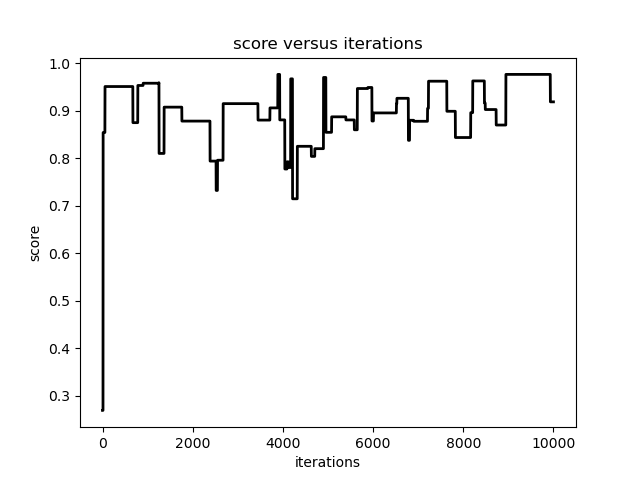

In [12]:
plt.close()
x=np.arange(0,n_iterations)
plt.plot(x, score_trace, ls="-", c="k", lw=2, label="$score$")
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('score versus iterations')
plt.savefig(cwd+'/picture/MCMC-sp-op.png')
plt.show()

In [13]:
# Define the thinning factor
thin_factor = 1000
burn_in = 1000
#remove the burn in samples
tmp=param_trace[burn_in::]
# Thin the parameter trace
thinned_trace = tmp[::thin_factor]

kde = stats.gaussian_kde(thinned_trace.T)
print(max(score_trace))

0.9766525419605756


In [14]:
x_range = np.linspace(0.01, 0.0238, 1000)
y_range = np.linspace(0.00, 0.15, 1000)
p_range = np.linspace(1.00, 3.00, 1000)

# Evaluate the posterior distribution on the range of values
xx, yy, pp = np.meshgrid(x_range, y_range, p_range)
pos = np.vstack([xx.ravel(), yy.ravel(), pp.ravel()])
z = np.reshape(kde(pos).T, xx.shape)

# Find the maximum of the posterior distribution
max_idx = np.argmax(z)
max_x = pos[0][max_idx]
max_y = pos[1][max_idx]
max_pp = pos[2][max_idx]
max_z = z.ravel()[max_idx]

In [15]:
print(max_x,max_y,max_pp,max_z)

0.01926906906906907 0.08693693693693694 1.7647647647647648 86514.85113851144


In [16]:
a,b,c = param_trace[np.argmax(score_trace)]
param_trace[np.argmax(score_trace)]

array([0.01810465, 0.05898908, 1.55796262])

overlap score:  0.48171192682386815
mase score:  tensor(0.9516, dtype=torch.float64)


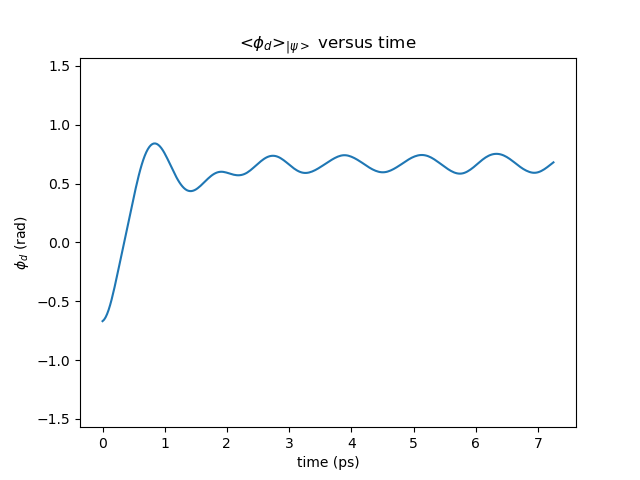

In [17]:
curr_f_params= {'sig':max_pp,'t0':0,'beta':0.1,'A0':max_x,'f0':max_y}
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=False)
print('overlap score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True))
print('mase score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True, overlap=False))

all_expect_pos = np.zeros(300)
Prob_den = D
dx = (x_max-x_min)/128
for i in range(300):
    Expect_pos = 0
    for j, x in enumerate(x_grid):
        expected = x*(Prob_den[i][j])*dx
        Expect_pos += expected
    all_expect_pos[i] = Expect_pos

plt.close()
plt.plot(y_grid, all_expect_pos)
plt.title('<$\phi_d$>$_{|\psi>}$ versus time')
plt.xlabel('time (ps)')
plt.ylim([x_min, x_max])
plt.ylabel('$\phi_d$ (rad)')
plt.savefig(cwd+'/picture/MCMC-sp-op-MCMC-expected.png')
plt.show()

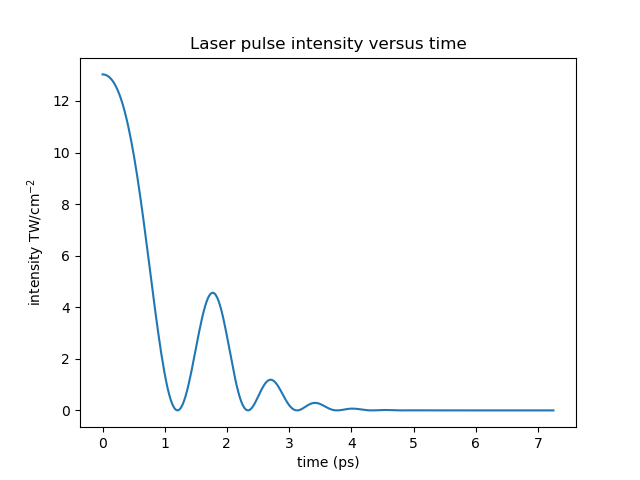

In [18]:
plot_intensity(y_grid, curr_f_params)

overlap score:  0.537761667941236
mase score:  tensor(0.9767, dtype=torch.float64)


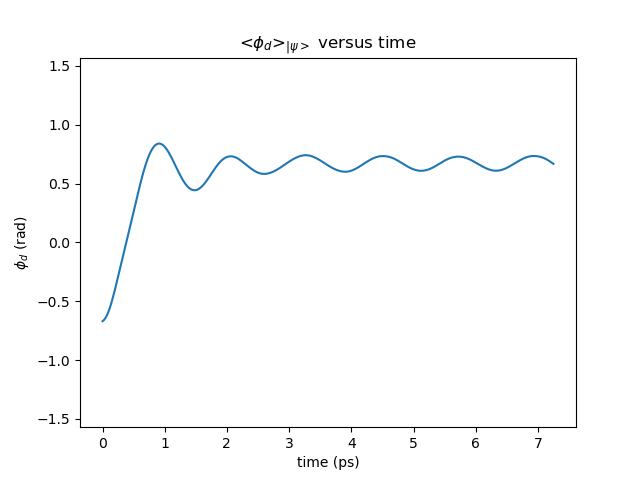

In [19]:
curr_f_params= {'sig':c,'t0':0,'beta':0.1,'A0':a,'f0':b}
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=False)
print('overlap score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True))
print('mase score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True, overlap=False))

all_expect_pos = np.zeros(300)
Prob_den = D
dx = (x_max-x_min)/128
for i in range(300):
    Expect_pos = 0
    for j, x in enumerate(x_grid):
        expected = x*(Prob_den[i][j])*dx
        Expect_pos += expected
    all_expect_pos[i] = Expect_pos

plt.close()
plt.plot(y_grid, all_expect_pos)
plt.title('<$\phi_d$>$_{|\psi>}$ versus time')
plt.xlabel('time (ps)')
plt.ylim([x_min, x_max])
plt.ylabel('$\phi_d$ (rad)')
plt.savefig(cwd+'/picture/MCMC-sp-op-max-expected.png')
plt.show()

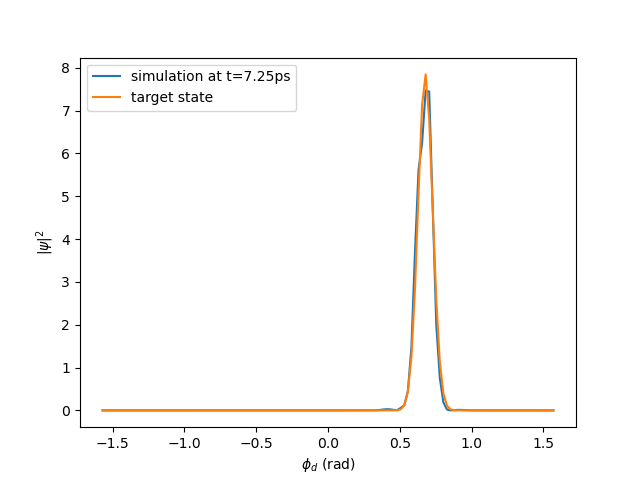

In [20]:
plt.close()
plt.plot(x_grid, D[-1], label='simulation at t=7.25ps')
plt.plot(x_grid, psi_start[::-1]**2, label='target state')
plt.ylabel('$|\psi|^2$')
plt.xlabel('$\phi_d$ (rad)')
plt.legend()
plt.show()